# ASHRAE - Great Energy Predictor III

### How much energy will a building consume?

#### Competition description

#### Q: How much does it cost to cool a skyscraper in the summer?

#### A: A lot! And not just in dollars, but in environmental impact.

#### ========================================================================================================

Thankfully, significant investments are being made to improve building efficiencies to reduce costs and emissions. The question is, are the improvements working? That’s where you come in. Under pay-for-performance financing, the building owner makes payments based on the difference between their real energy consumption and what they would have used without any retrofits. The latter values have to come from a model. Current methods of estimation are fragmented and do not scale well. Some assume a specific meter type or don’t work with different building types.

#### ========================================================================================================

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

### Note: 
The competition is ongoing at the time of this posting and the rules prevent me from posting the solution before conclusion

In [59]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML

HTML('<iframe width="1106" height="622" src="https://www.youtube.com/embed/2-G20qed5eg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [60]:
JUPYTER_NB = True

import numpy as np 
import pandas as pd 
pd.set_option('max_columns', 150)

import os,random, math, psutil, pickle

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

if JUPYTER_NB:
    # Jupyter nb only
    import plotly.graph_objs as go 
    import plotly.express as px
    import plotly.offline as py
    py.init_notebook_mode(connected=True)
    from plotly.offline import init_notebook_mode, iplot
    init_notebook_mode(connected=True)
    from plotly import tools, subplots
    py.init_notebook_mode(connected=True)


root = 'C:/Users/dmcul/KAGGLE_COMPETITIONS/ashrae-energy-prediction/'
print(os.listdir(root))

# Import the files

# train files
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
# test files
test_df = pd.read_csv(root + 'test.csv')
# weather train
weather_train_df = pd.read_csv(root + 'weather_train.csv')
# weather test
weather_test_df = pd.read_csv(root + 'weather_test.csv')
# building meta
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
# Sample submission
sample_submission = pd.read_csv(root + 'sample_submission.csv')

# Check the imports
print('Size of train_df data', train_df.shape)
print('Size of test_df data', test_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

# add row_id and change the column order
train_df['row_id'] = train_df.index
new_columns = ['row_id','building_id', 'meter', 'timestamp', 'meter_reading']
train_df = train_df[new_columns]


# official correction from BTU to kWh as of 11/27/2019
train_df['meter_reading'] = 0.2931 * train_df['meter_reading'] 

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'train.csv', 'weather_test.csv', 'weather_train.csv']
Size of train_df data (20216100, 4)
Size of test_df data (41697600, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


# Memory reduction

With sets this large, memory management becomes critical

In [61]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # limits the extent of int8 range
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 366.31 Mb (52.5% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


# Visualize meter missing data

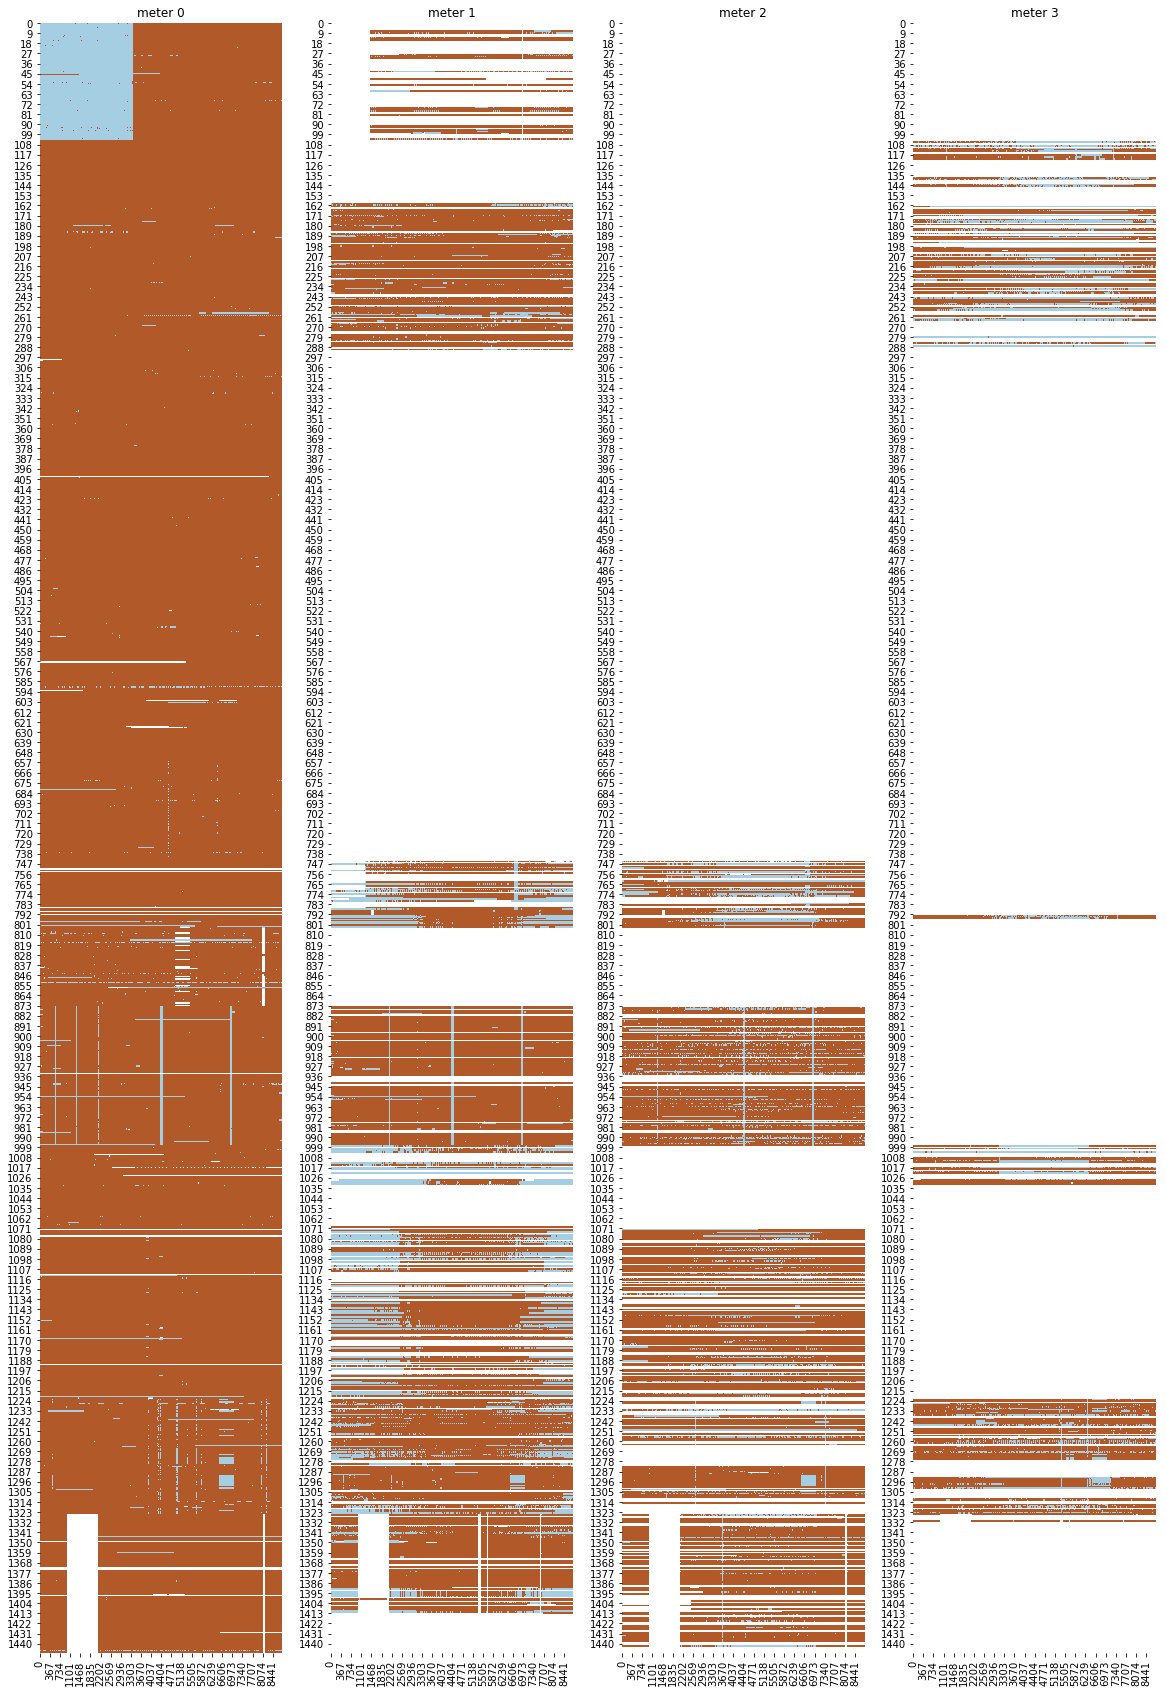

In [28]:
# Visualize missing data for each meter type:
train = train_df.set_index(['timestamp'])

# Plot missing values per building/meter
f,a=plt.subplots(1,len(np.unique(train_df.meter)),figsize=(20,30))
for meter in np.arange(len(np.unique(train_df.meter))):
    df = train[train.meter==meter].copy().reset_index()
    df['timestamp'] = pd.to_timedelta(df.timestamp).dt.total_seconds() / 3600
    df['timestamp'] = df.timestamp.astype(int)
    df.timestamp -= df.timestamp.min()
    missmap = np.empty((1449, df.timestamp.max()+1))
    missmap.fill(np.nan)
    for l in df.values:
        if l[3]!=meter:continue
        #print(int(l[1]))
        missmap[int(l[2]), int(l[0])] = 0 if l[4]==0 else 1 #Columns: [timestamp, building_id, meter, meter_reading]
    a[meter].set_title(f'meter {meter:d}')
    sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

# Legend:

#### X axis: hours elapsed since Jan 1st 2016, for each of the 4 meter types
#### Y axis: building_id
#### Brown: meter reading available with non-zero value
#### Light blue: meter reading available with zero value
#### White: missing meter reading

Note: The vertical lines are suspicious. They reflect temporay lack of data. For a reason or another, the meters didn't run during that time. This information can be used during filling the missing data phase

# Joining the data

In [62]:
# Join all dataset: train+weathe+site; test+weathe+site
train_df['timestamp'] = pd.to_datetime(train_df['timestamp']) # datetime
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
#print(train_df['timestamp'].dtype)

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])
    
building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)
#print(train_df['timestamp'].dtype) #datetime

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df


# the order of columns IS VERY IMPORTANT. Let's sync column order between train and test dataframes
columns=[c for c in train_df.columns if c != 'meter_reading']
test_df=test_df[columns]

# Feature engineering

In [30]:
# Feature engineering

# ADD columns
# Datetime: extract year, quarter, month, datetime to date

# Train
train_df['year'] = train_df['timestamp'].dt.year.astype(np.int8)
train_df['quarter'] = train_df['timestamp'].dt.quarter.astype(np.int8)
train_df['month'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['timestamp'] = train_df['timestamp'].dt.date

# Test
test_df['year'] = test_df['timestamp'].dt.year.astype(np.int8)
test_df['quarter'] = test_df['timestamp'].dt.quarter.astype(np.int8)
test_df['month'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['timestamp'] = test_df['timestamp'].dt.date


# Add Age
train_df['age'] = (train_df['year'].max() - train_df['year_built'].max() + 1).astype(np.int8)
test_df['age'] = (test_df['year'].max() - test_df['year_built'].max() + 1).astype(np.int8)


# wind speed in kmh
train_df['wind_kmh'] = (train_df['wind_speed'] * 3.6).astype(np.float16)
test_df['wind_kmh'] = (test_df['wind_speed'] * 3.6).astype(np.float16)

# windchill
train_df['windchill'] = (13.12 + train_df['air_temperature'] * 0.6215 - (11.37 * train_df['wind_kmh']**0.16) + (0.3965 * train_df['air_temperature'] * train_df['wind_kmh']**0.16)).astype(np.float16)

test_df['windchill'] = (13.12 + test_df['air_temperature'] * 0.6215 - (11.37 * test_df['wind_kmh']**0.16) + (0.3965 * test_df['air_temperature'] * test_df['wind_kmh']**0.16)).astype(np.float16)

# DROP columns - two more column to drop before running the model: timestamp, row_id
drop_cols =['row_id','wind_speed','year_built','year', 'precip_depth_1_hr', 'wind_direction', 'sea_level_pressure', 'dew_temperature','cloud_coverage']

train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)

# check the data
print('Size of train_df data', train_df.shape)
print('Size of test_df data', test_df.shape)
print('\nTraining data:\n',train_df.head())
print('\nTesting data:\n',test_df.head())

Size of train_df data (20216100, 14)
Size of test_df data (41697600, 13)

Training data:
    building_id  meter   timestamp  meter_reading  site_id primary_use  \
0            0      0  2016-01-01            0.0        0   Education   
1            1      0  2016-01-01            0.0        0   Education   
2            2      0  2016-01-01            0.0        0   Education   
3            3      0  2016-01-01            0.0        0   Education   
4            4      0  2016-01-01            0.0        0   Education   

   square_feet  floor_count  air_temperature  quarter  month  age  wind_kmh  \
0         7432          NaN             25.0        1      1    1       0.0   
1         2720          NaN             25.0        1      1    1       0.0   
2         5376          NaN             25.0        1      1    1       0.0   
3        23685          NaN             25.0        1      1    1       0.0   
4       116607          NaN             25.0        1      1    1       0.0 

# Outliers

In [31]:
# rename categories
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})

# rename dataframes
daily_train = train_df.copy()

daily_train = daily_train.groupby(['timestamp', 'building_id', 'meter']).sum()

# Aggregate data for all buildings on a daily basis at the meter level
daily_train_agg = daily_train.groupby(['timestamp', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])# 'idxmax' + DataFrame version of ndarray.argmax

daily_train_agg = daily_train_agg.reset_index()

level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)

level_0 = ['' if x == '' else '-' + x for x in level_0]

daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)

,timestamp,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,quarter-sum,quarter-mean,quarter-idxmax,quarter-max,month-sum,month-mean,month-idxmax,month-max,age-sum,age-mean,age-idxmax,age-max,wind_kmh-sum,wind_kmh-mean,wind_kmh-idxmax,wind_kmh-max,windchill-sum,windchill-mean,windchill-idxmax,windchill-max
0,2016-01-01,electricity,1.236779e+06,890.409363,"(2016-01-01, 803, electricity)",3.401050e+04,228225.0,164.308855,"(2016-01-01, 1326, electricity)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, electricity)",21000000.0,30848.0,22.203125,"(2016-01-01, 799, electricity)",624.0,inf,153.375000,"(2016-01-01, 0, electricity)",560.00,33300.0,23.974082,"(2016-01-01, 0, electricity)",24.0,33300.0,23.974082,"(2016-01-01, 0, electricity)",24.0,33300.0,23.974082,"(2016-01-01, 0, electricity)",24.0,inf,304.250,"(2016-01-01, 1033, electricity)",766.50,inf,122.937500,"(2016-01-01, 0, electricity)",633.000
1,2016-01-01,chilledwater,4.139067e+05,905.703918,"(2016-01-01, 1289, chilledwater)",3.054443e+04,107738.0,235.750547,"(2016-01-01, 1326, chilledwater)",360.0,1.409027e+09,3.083211e+06,"(2016-01-01, 1148, chilledwater)",20676576.0,3648.0,7.984375,"(2016-01-01, 799, chilledwater)",624.0,32960.0,72.125000,"(2016-01-01, 161, chilledwater)",234.25,10902.0,23.855580,"(2016-01-01, 161, chilledwater)",24.0,10902.0,23.855580,"(2016-01-01, 161, chilledwater)",24.0,10902.0,23.855580,"(2016-01-01, 161, chilledwater)",24.0,inf,254.625,"(2016-01-01, 1070, chilledwater)",409.25,18928.0,41.437500,"(2016-01-01, 161, chilledwater)",382.250
2,2016-01-01,steam,2.014535e+07,64157.167969,"(2016-01-01, 1099, steam)",1.493368e+07,87728.0,279.388535,"(2016-01-01, 1326, steam)",360.0,1.061216e+09,3.379670e+06,"(2016-01-01, 1148, steam)",20676576.0,2592.0,8.257812,"(2016-01-01, 799, steam)",624.0,9208.0,29.328125,"(2016-01-01, 875, steam)",188.25,7514.0,23.929936,"(2016-01-01, 745, steam)",24.0,7514.0,23.929936,"(2016-01-01, 745, steam)",24.0,7514.0,23.929936,"(2016-01-01, 745, steam)",24.0,inf,303.750,"(2016-01-01, 1072, steam)",409.25,-14536.0,-46.281250,"(2016-01-01, 745, steam)",232.375
3,2016-01-01,hotwater,4.718879e+05,3276.999268,"(2016-01-01, 1331, hotwater)",6.443057e+04,26526.0,184.208333,"(2016-01-01, 1325, hotwater)",360.0,3.903113e+08,2.710495e+06,"(2016-01-01, 794, hotwater)",17566680.0,3120.0,21.671875,"(2016-01-01, 114, hotwater)",312.0,15848.0,110.062500,"(2016-01-01, 163, hotwater)",234.25,3405.0,23.645833,"(2016-01-01, 106, hotwater)",24.0,3405.0,23.645833,"(2016-01-01, 106, hotwater)",24.0,3405.0,23.645833,"(2016-01-01, 106, hotwater)",24.0,29232.0,203.000,"(2016-01-01, 106, hotwater)",386.25,17808.0,123.687500,"(2016-01-01, 163, hotwater)",382.250
4,2016-01-02,electricity,1.257092e+06,904.382446,"(2016-01-02, 803, electricity)",3.393416e+04,228472.0,164.368345,"(2016-01-02, 1326, electricity)",360.0,3.084779e+09,2.219266e+06,"(2016-01-02, 869, electricity)",21000000.0,30896.0,22.218750,"(2016-01-02, 799, electricity)",624.0,inf,146.375000,"(2016-01-02, 0, electricity)",469.00,33311.0,23.964748,"(2016-01-02, 0, electricity)",24.0,33311.0,23.964748,"(2016-01-02, 0, electricity)",24.0,33311.0,23.964748,"(2016-01-02, 0, electricity)",24.0,inf,314.250,"(2016-01-02, 656, electricity)",634.00,inf,99.062500,"(2016-01-02, 0, electricity)",473.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2016-12-30,hotwater,6.090187e+05,4200.128906,"(2016-12-30, 1021, hotwater)",1.501905e+05,27152.0,187.255172,"(2016-12-30, 1325, hotwater)",360.0,4.008614e+08,2.764561e+06,"(2016-12-30, 794, hotwater)",17566680.0,3092.0,21.312500,"(

# Visualizing data

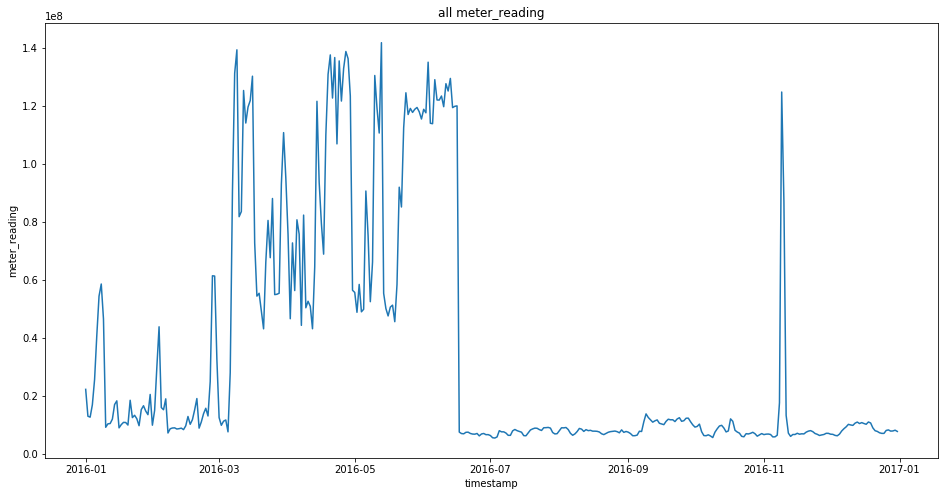

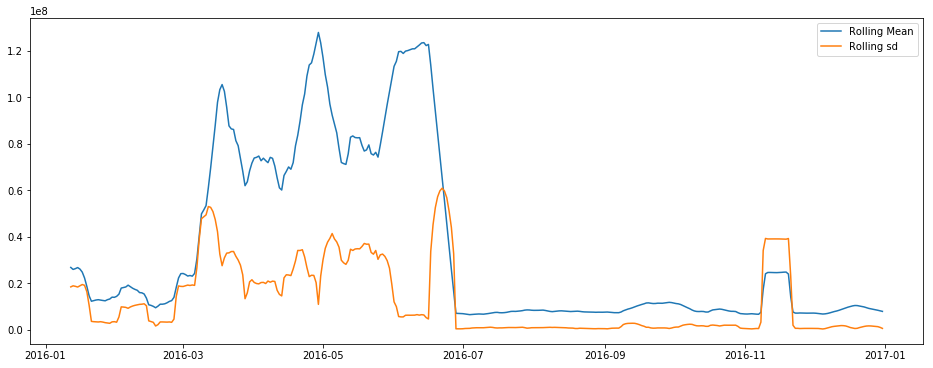

In [32]:
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('all meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts)
plt.show()
plt.close();


plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()
plt.show()
plt.close();

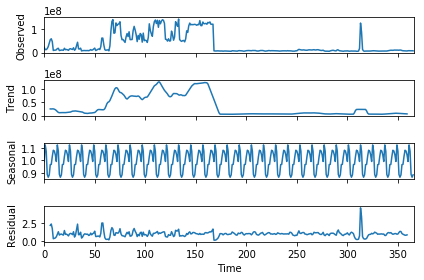

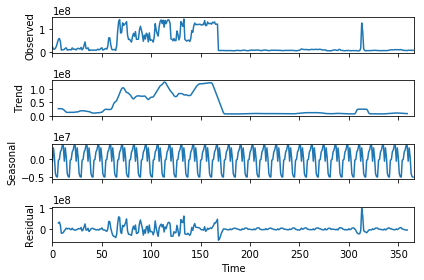

In [33]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()
#plt.close()

# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()
#plt.close()

Text(0.5, 1.0, 'Meter man values, all meters aggregated')

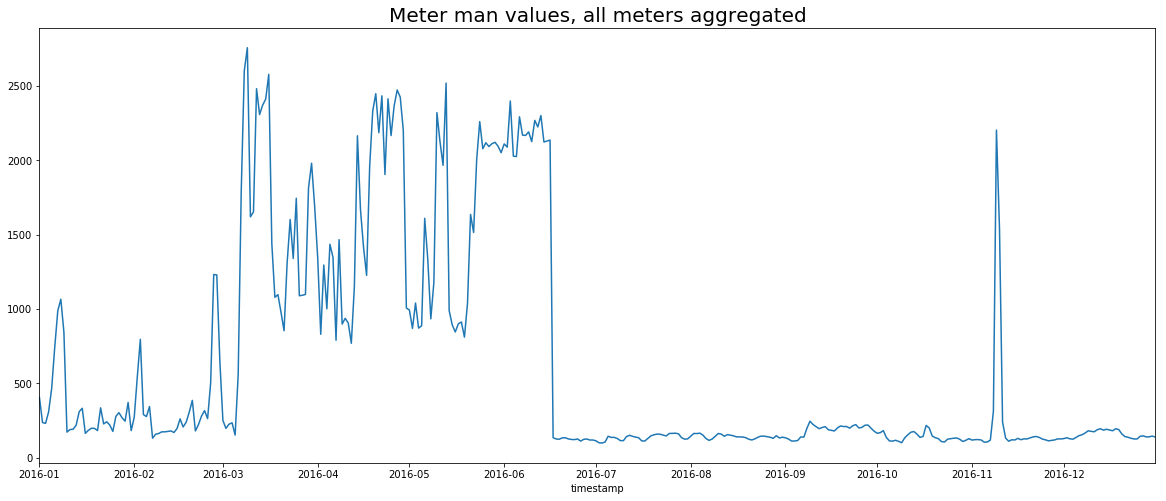

In [34]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))
plt.title('Meter man values, all meters aggregated', fontsize=20)

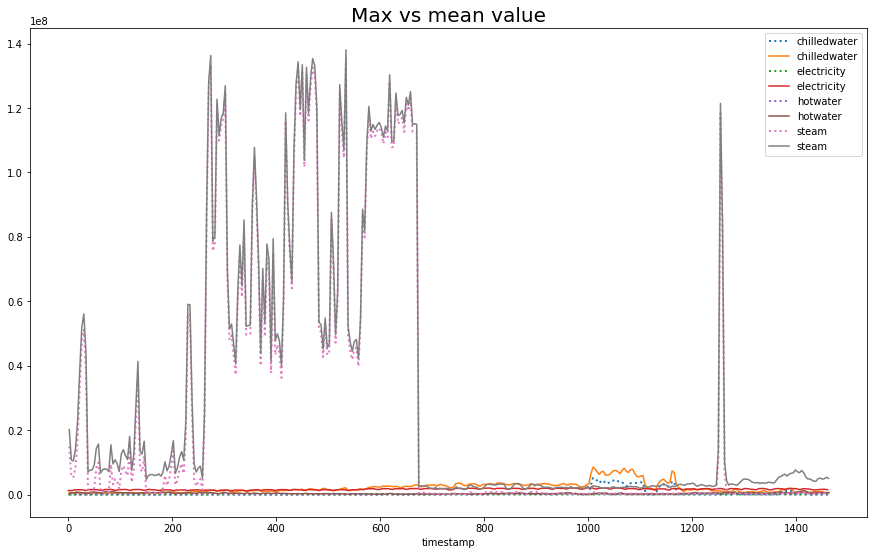

In [35]:
meter = np.unique(pd.Series(daily_train_agg['meter']))
dates = np.unique(pd.to_datetime(daily_train_agg['timestamp']).dt.date.values.astype('M8[D]'))

plt.figure(figsize=(15,9))
#plt.style.use('ggplot')
for i in meter:
    plt.plot(daily_train_agg['meter_reading-max'][daily_train_agg['meter']==i], label = i, linestyle = ':', lw=2)
    plt.plot(daily_train_agg['meter_reading-sum'][daily_train_agg['meter']==i], label = i)
    #plt.plot_date(dates, daily_train_agg['meter_reading-sum'][daily_train_agg['meter']==i], label = i, alpha=.7)
    plt.xlabel('timestamp')
    plt.title('Max vs mean value', fontsize = 20)
    plt.legend()
plt.show()
plt.close()

The mean values are completely driven by ONE big @$$ outlier: the shapes of mean and max are identical. The mean is driven by the one mega outlier. There is absolutely no information, or maybe there is confusing information: looking when the maximum values happened, I was convinced this must be some southern hemisphere data.

# Identify and remove outliers

In [36]:
outlier_bld_id = []

daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]

# electricity ourliers
print('\n\nNumber of days that a building has the maximum electricity consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 6 buildings:\n')

outlier_electricity = daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].unique()

outlier_electricity 

for i in outlier_electricity:
    outlier_bld_id.append(i)


# chilled water
print('\n\nNumber of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 10 buildings:\n')
outlier_chilled_w = daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].unique()
print(outlier_chilled_w)
for i in outlier_chilled_w:
    outlier_bld_id.append(i)

# steam
print('\n\nNumber of days that a building has the maximum steam consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 4 buildings:\n')
outlier_steam = daily_train_agg[daily_train_agg['meter'] == 'steam']['building_id_max'].unique()
print(outlier_steam)
for i in outlier_steam:
    outlier_bld_id.append(i)

#Hotwater
print('\n\nNumber of days that a building has the maximum hotwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].value_counts())
print('The max values of electricity are caused by only 7 buildings:\n')
outlier_hotwater = daily_train_agg[daily_train_agg['meter'] == 'hotwater']['building_id_max'].unique()
print(outlier_hotwater)
for i in outlier_hotwater:
    outlier_bld_id.append(i)

print(outlier_bld_id)

# drop outliers
s1 = train_df.shape[0]

for i in outlier_bld_id:
    train_df = train_df[train_df['building_id'] != i]

dropped_rows = s1 - train_df.shape[0]
print('Dropped rows due to outliers:',dropped_rows)



Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64
The max values of electricity are caused by only 6 buildings:



Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64
The max values of electricity are caused by only 10 buildings:

[1289 1258 1284   29   76 1156   60  778 1088   50]


Number of days that a building has the maximum steam consumption of all the buildings:

1099    158
1197    101
1168    100
1148      7
Name: building_id_max, dtype: int64
The max values of electricity are caused by only 4 buildings:

[1099 1197 1168 1148]


Number of days that a building has the maximum hotwater consumption of all the buildings:

1021    229


# Visualizing data after outlier removal

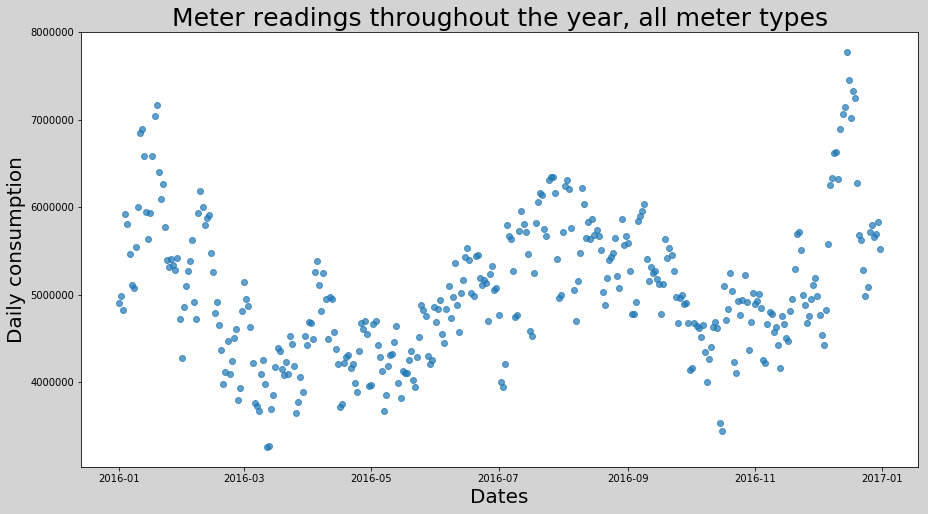

In [37]:
# meter readings regardless of energy type
dates = np.unique(pd.to_datetime(daily_train_agg['timestamp']).dt.date.values.astype('M8[D]'))


daily_meter_reading = train_df.groupby(['timestamp'])['meter_reading'].sum()

plt.figure(figsize=(15,8),facecolor='lightgrey')
plt.title('Meter readings throughout the year, all meter types',  fontsize=25)
plt.plot_date(dates, daily_meter_reading, alpha=.7)
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.show()
plt.close()

Now we can see patterns consistent with the northern hemisphere: high consumption during winter and at the peak of the summer. The signal was retrieved from the noise

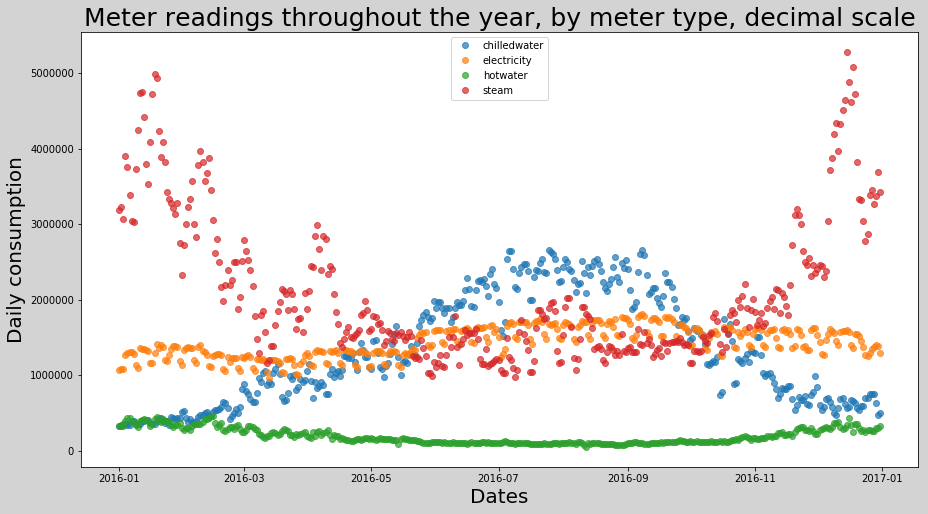

In [38]:
# meter types
meter_type = np.unique(train_df['meter'].values)

# meter readings, all energy types
daily_meter_alltype = train_df.groupby(['timestamp','meter'])['meter_reading'].sum()
daily_meter_alltype = daily_meter_alltype.reset_index()

# store readings by meter type
key=list(meter_type)
val=list(np.zeros(len(meter_type)))
meter_type_yearly = {k:v for k,v in zip(key, val)}

# meter readings by energy type
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in meter_type:
    yearly = []
    daily_readings = daily_meter_alltype[daily_meter_alltype['meter']==i]['meter_reading']
    yearly.append(daily_readings)
    plt.plot_date(dates, daily_readings, alpha=.7, label=i)
    meter_type_yearly[i] += np.array(yearly).sum()
    
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by meter type, decimal scale',  fontsize=25)

plt.show()
plt.close()

#### We see different patterns for different meter types:

       - chilled water peaks in the heat of the summer
       - steam plummets during the summer months
       - electricity looks steady throughout
       - hotwater dips during the summer months and peaks in the cold season
       
 Now data starts to make sense

# Logarithmic scale

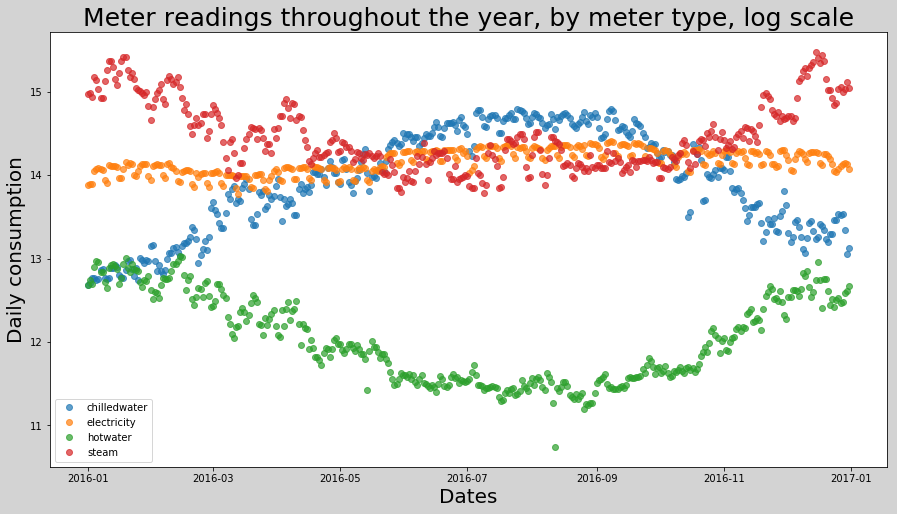

In [39]:
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in meter_type:
    daily_meter_type = daily_meter_alltype[daily_meter_alltype['meter']==i]['meter_reading']
    plt.plot_date(dates, np.log1p(daily_meter_type), alpha=.7, label=i)
    
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by meter type, log scale',  fontsize=25)

plt.show()
plt.close()

# Summarize the energy usage

In [40]:
# dict to dataframe
meter_type_yearly_df = pd.DataFrame.from_dict(meter_type_yearly, orient='index', columns=['metertype_yearly'])
m_type_yearly = meter_type_yearly_df.sort_values('metertype_yearly', ascending = False)
print(m_type_yearly)

              metertype_yearly
steam              763738368.0
electricity        524014688.0
chilledwater       482820448.0
hotwater            70276160.0


# Primary use types

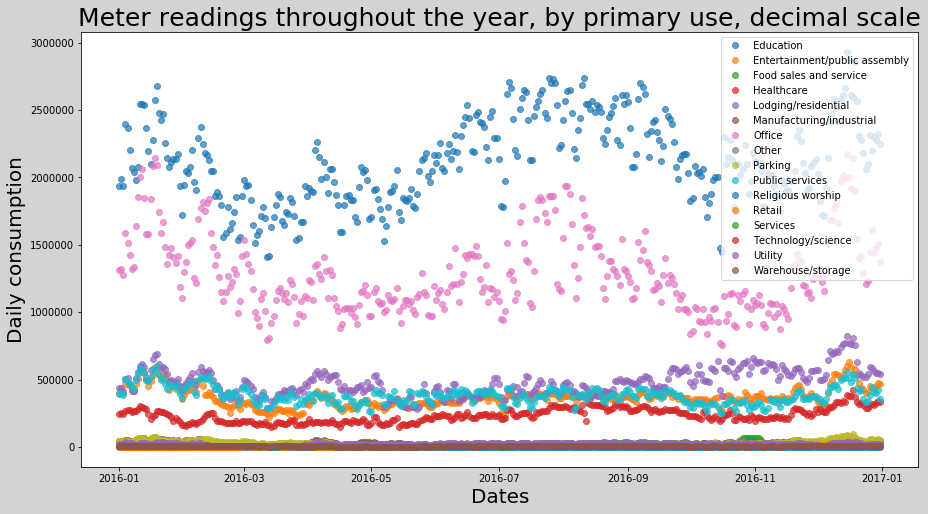

In [41]:
primary_use_type = np.unique(train_df['primary_use'].values)

# meter readings, all use types
daily_use_all = train_df.groupby(['timestamp','primary_use'])['meter_reading'].sum()
daily_use_all = daily_use_all.reset_index()

# store the meter readings by primary use in dict
ky=list(primary_use_type)
vl=list(np.zeros(len(list(primary_use_type))))
primary_use_yearly = {k:v for k,v in zip(ky,vl)}

# meter readings by primary use type, decimal scale
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in primary_use_type:
    daily = []
    daily_use_type = daily_use_all[daily_use_all['primary_use']==i]['meter_reading']
    daily.append(daily_use_type)
    plt.plot_date(dates, daily_use_type, alpha=.7, label=i)
    primary_use_yearly[i] += np.array(daily).sum()
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by primary use, decimal scale',  fontsize=25)
plt.show()
plt.close()

The picture is becoming crowded but the main message is we see at least three or four clusterings of patterns of energy usage. We can use this information in our prediction architecture

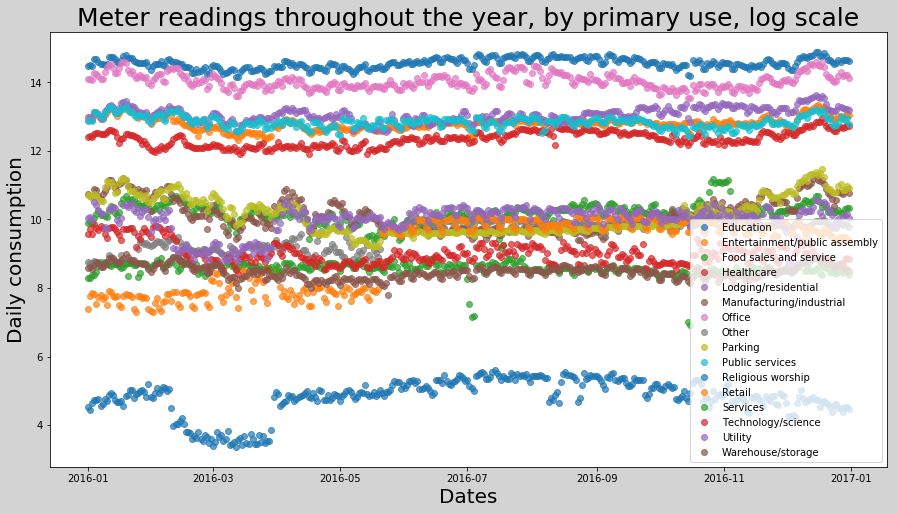

In [42]:
# meter readings by primary use type, log scale
plt.figure(figsize=(15,8),facecolor='lightgrey')
for i in primary_use_type:
    daily_use_type = daily_use_all[daily_use_all['primary_use']==i]['meter_reading']
    plt.plot_date(dates, np.log1p(daily_use_type), alpha=.7, label=i)
    
plt.legend()
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Daily consumption', fontsize=20)
plt.title('Meter readings throughout the year, by primary use, log scale',  fontsize=25)
plt.show()
plt.close()

Let's see a more legible breakdown of energy usage by primary use:

In [43]:
# dict to dataframe
primary_use_yearly_df = pd.DataFrame.from_dict(primary_use_yearly, orient='index', columns=['primary_use_yearly'])
primary_use = primary_use_yearly_df.sort_values('primary_use_yearly',ascending=False)
print(primary_use)

                               primary_use_yearly
Education                            7.775697e+08
Office                               4.681588e+08
Lodging/residential                  1.759697e+08
Public services                      1.404797e+08
Entertainment/public assembly        1.353895e+08
Healthcare                           8.627430e+07
Parking                              1.061439e+07
Manufacturing/industrial             1.053430e+07
Food sales and service               1.019606e+07
Utility                              8.446365e+06
Other                                5.680922e+06
Retail                               4.615582e+06
Technology/science                   3.144489e+06
Services                             1.942549e+06
Warehouse/storage                    1.782348e+06
Religious worship                    5.098995e+04


# Examine the missing values

In [44]:
# checking missing data for train_df
total_train = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total_train, percent], axis=1, keys=['Total', 'Percent'])
print('\nMissing train data:\n',missing_train_data.head(4))

# checking missing data for train_df
total_test = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([total_test, percent], axis=1, keys=['Total', 'Percent'])
print('\nMissing test data:\n',missing_test_data.head(4))


Missing train data:
                     Total    Percent
floor_count      16241623  82.753706
windchill          140588   0.716319
wind_kmh           139075   0.708610
air_temperature     93130   0.474512

Missing test data:
                     Total    Percent
floor_count      34444320  82.605042
windchill          313413   0.751633
wind_kmh           302089   0.724476
air_temperature    221901   0.532167
